# Merging visits into stays

In order to have a precise view of each patient's course of care, it can be useful to **merge together visit occurrences into stays.**

A crude way of doing so is by using the `preceding_visit_occurrence_id` column in the `visit_occurrence` table. However, this columns isn't always filled, and a lot of visits would be missed by using only this method.

The method proposed here relies on **how close two visits are** in order to put them in the same stay. This is the role of the `merge_visits()` functions:

In [ ]:
import eds_scikit
spark, sc, sql = eds_scikit.improve_performances()

In [2]:
from eds_scikit.period.stays import merge_visits

Another function, `get_stays_duration()`, can then be used to extract a *stay DataFrame* with useful informations:

In [3]:
from eds_scikit.period.stays import get_stays_duration

In [4]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

## Loading data

In [ ]:
import databricks.koalas as ks
import pandas as pd

import altair as alt

from datetime import datetime, timedelta

from eds_scikit.io import HiveData
from eds_scikit.utils.datetime_helpers import substract_datetime

data = HiveData(spark, database_name='eds_lib_poc')

vo = data.visit_occurrence

This cohort is of reasonnable size, so we can work with Pandas in this case:

In [ ]:
vo_pd = vo.to_pandas()

## Getting stays

We can now merge visits into stays. Check the corresponding documentation for more informations about each individual parameter

In [12]:
vo_pd = merge_visits(vo_pd,
    remove_deleted_visits=True,
    long_stay_threshold=timedelta(days=365),
    long_stay_filtering='all',
    max_timedelta=timedelta(days=2),
    merge_different_hospitals=False,
    merge_different_source_values=['hospitalisés', 'urgence'],
)

This functions will add a `'STAY_ID'` column, corresponding to the `visit_occurrence_id` of the first visit of the stay.  
We can check that indeed, most stays are composed of a single visit (notice that the Y-axis is in **log** scale):

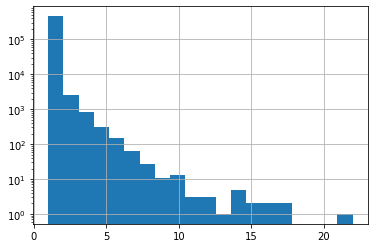

In [13]:
stats = vo_pd.groupby('STAY_ID').visit_occurrence_id.count()
_ = stats.hist(bins=20, log=True)

We can finally display the number of merged visits:

In [14]:
stats[stats > 1].sum()

42738

or in % of the total number of visits:

In [15]:
round(100 * stats[stats > 1].sum() / len(vo_pd),2)

8.69

## Getting stays durations

This second function generates an easy-to-use *stay DataFrame*:  
We will only focus on emergency and hospitalisation for this part, which is no problem since we only allowed merging those two types of stay (via `merge_different_source_values=['hospitalisés', 'urgence']`)

In [34]:
vo_pd = vo_pd[vo_pd.visit_source_value.isin(['hospitalisés', 'urgence'])]

In [35]:
stays = get_stays_duration(
    vo_pd, 
    algo='visits_date_difference', 
    missing_end_date_handling='coerce'
)

In [36]:
stays.head()

,person_id,t_start,t_end,STAY_DURATION
STAY_ID,,,,
-2.147468e+09,-793380275,2017-08-22 18:45:00,2017-08-25 14:24:00,67.650000
-2.147465e+09,-1632607976,2019-12-03 12:20:00,2019-12-03 13:42:00,1.366667
-2.147450e+09,56307107,2019-04-23 17:18:00,2019-04-25 16:21:00,47.050000
-2.147433e+09,-916176344,2021-04-23 10:40:00,2021-04-23 11:50:00,1.166667
-2.147431e+09,1814301591,2018-06-06 14:25:00,2018-06-06 15:24:00,0.983333


Let us compare the distribution of stay/visit durations.  

In [38]:
# Extracting visit duration (in hours)
vo_pd['VISIT_DURATION'] = substract_datetime(vo_pd['visit_end_datetime'], vo_pd['visit_start_datetime'], out='hours')

# COnverting to days
stays['STAY_DURATION'] = stays['STAY_DURATION']/24
vo_pd['VISIT_DURATION'] = vo_pd['VISIT_DURATION']/24

# Keeping only visits/stays less than a month long
vo_pd = vo_pd[vo_pd['VISIT_DURATION'] <= 31]
stays = stays[stays['STAY_DURATION'] <= 31]

In [39]:
stays.STAY_DURATION.mean()

2.306892174348691

In [40]:
vo_pd.VISIT_DURATION.mean()

2.2188916112474866

We will aggregate the data into bins of 1 week

In [41]:
days = list(range(1,32))

stays_distribution = pd.cut(stays['STAY_DURATION'], 31, labels=days).value_counts(normalize=True).sort_index()
visits_distribution = pd.cut(vo_pd['VISIT_DURATION'], 31, labels=days).value_counts(normalize=True).sort_index()

data = pd.concat([
    pd.DataFrame(data = {'density':stays_distribution.values, 'day':stays_distribution.index, 'type':'STAY'}),
    pd.DataFrame(data = {'density':visits_distribution.values, 'day':visits_distribution.index, 'type':'VISIT'})
])

In [42]:
diff_distribution = (stays_distribution - visits_distribution).to_frame().reset_index()
diff_distribution.columns = ['day','difference']

In [43]:
alt.Chart(data).mark_bar(opacity=0.5).encode(
    x="day:N",
    y=alt.Y("density:Q",stack=None, scale=alt.Scale(type='log')),
    color=alt.Color("type:N", title='Type')
).properties(
    width=800
)

alt.Chart(...)

Plotting the difference between those two distributions shows that
- Some short visits ( < 1 week ) seems to be merged into longer stays
- This cause stays of duration ~ N weeks to be more frequent than visits of duration ~ N weeks


In [45]:
alt.Chart(diff_distribution).mark_bar().encode(
    x=alt.X("day:N", title="Day"),
    y=alt.Y("difference:Q", title='Difference between stay and visit distribution')
).properties(
    width=800
)

alt.Chart(...)